In [23]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import mne
import matplotlib.pyplot as plt
import pandas as pd
import os
from copy import deepcopy
import pywt

In [24]:
def read_edf(file_path):

    raw = mne.io.read_raw_edf(file_path, preload=True)

    data, times = raw[:]

    freq = raw.info["sfreq"]
    channel_labels = raw.info['ch_names']
    

    return data, times, freq, channel_labels

# Preprocessing

In [3]:
def truncate_data_to_min_data_len(data, len_after_truncate):
    len_to_be_truncated = data.shape[-1] - len_after_truncate
    data_new = deepcopy(data)
    data_new = data_new[:, (int(len_to_be_truncated / 2)) : (-int(len_to_be_truncated / 2))]
    return data_new



In [4]:
def normalizing_data(data, method="min_max"):
    if method == "min_max":
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    
    return scaler.fit_transform(data.T).T 



# Dataset creation

In [5]:
dirpath = "eeg-during-mental-arithmetic-tasks-1.0.0"

files = sorted([file for file in os.listdir(dirpath) if "Subject" in file])

In [6]:
info = pd.read_csv(f"{dirpath}{os.path.sep}subject-info.csv")
info.head()

,Subject,Age,Gender,Recording year,Number of subtractions,Count quality
0,Subject00,21,F,2011,9.70,0
1,Subject01,18,F,2011,29.35,1
2,Subject02,19,F,2012,12.88,1
3,Subject03,17,F,2010,31.00,1
4,Subject04,17,F,2010,8.60,0


In [7]:
LEN_RESTING_SIGNAL = 31000

In [8]:
dataset = "filepath,recording_state,count_quality"
for file in files:
    subject, recording_state = file.split("_")
    recording_state = int(recording_state.split(".")[0]) - 1
    count_quality = info[info["Subject"] == subject]["Count quality"].values[0]
    dataset += "\n"
    dataset += f"{file},{recording_state},{count_quality}"

with open("eeg_menthal_arithmetics_dataset.csv", mode="w") as f:
    f.write(dataset)


In [9]:
df = pd.read_csv("eeg_menthal_arithmetics_dataset.csv")

In [10]:
df

,filepath,recording_state,count_quality
0,Subject00_1.edf,0,0
1,Subject00_2.edf,1,0
2,Subject01_1.edf,0,1
3,Subject01_2.edf,1,1
4,Subject02_1.edf,0,1
...,...,...,...
67,Subject33_2.edf,1,1
68,Subject34_1.edf,0,1
69,Subject34_2.edf,1,1
70,Subject35_1.edf,0,1


In [11]:
def get_x_y(path, label = "recording_state", dirpath = "eeg-during-mental-arithmetic-tasks-1.0.0"):
    df = pd.read_csv(path)
    X, Y = [], []
    for index, row in df.iterrows():
        if label == "recording_state":
            signal = read_edf(os.path.join(dirpath, row["filepath"]))[0]
            # print(row["recording_state"], row["recording_state"] == 0)
            if row["recording_state"] == 0:
                # print("HERE", row)
                signal = truncate_data_to_min_data_len(signal, LEN_RESTING_SIGNAL)
                # print(signal2.shape)
            Y.append(row["recording_state"])
            X.append(signal)
        else:
            if row["recording_state"] == 0:
                continue
            X.append(read_edf(os.path.join(dirpath, row["filepath"]))[0])
            Y.append(row["count_quality"])

    # X = [read_edf(os.path.join(dirpath, file))[0] for file in df["filepath"].values]
    # if label == "recording_state":
    #     Y = df["recording_state"].values
    # else: 
    #     Y = df["count_quality"].values
    return np.array(X), np.array(Y)


In [68]:
X, Y = get_x_y("eeg_menthal_arithmetics_dataset.csv")
# X = np.stack(X, axis=0)
# Y = np.array(Y)


Extracting EDF parameters from /Users/shevdan/Documents/Programming/signals/project/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /Users/shevdan/Documents/Programming/signals/project/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Extracting EDF parameters from /Users/shevdan/Documents/Programming/signals/project/eeg-during-mental-arithmetic-tasks-1.0.0/Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /Users/shevdan/Documents/Programming/signals/project/eeg-during-mental-arithmetic-tasks-1.0.0/Subject01_2.edf...
EDF fil

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# Preprocessing

# Plotting

In [30]:
data, times, freq, labels = read_edf("eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_1.edf")
SAMPLING_RATE = freq

Extracting EDF parameters from /Users/shevdan/Documents/Programming/signals/project/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


In [31]:
def plot_signals(signals, time, signal_labels, plot_type="signal", sampling_rate = 500):
    num_signals = signals.shape[0]

    plt.figure(figsize=(15, 2 * num_signals))
    for i in range(num_signals):
        if plot_type == "signal":
            plt.subplot(num_signals, 1, i + 1)
            plt.plot(time, signals[i, :])
            plt.title(signal_labels[i])
            plt.xlabel('Time')
            plt.ylabel('Amplitude')
        else:
            spectrum = np.fft.fft(signals[i, :])
            freq_x = np.fft.fftfreq(len(signals[i, :]), 1 / sampling_rate)
            positive_freq_indices = np.where(freq_x >= 0)
            spectrum = spectrum[positive_freq_indices]
            freq_x = freq_x[positive_freq_indices]
            amplitude_spectrum = np.abs(spectrum)/len(spectrum)



            plt.subplot(num_signals, 1, i + 1)
            plt.stem(freq_x, amplitude_spectrum)
            plt.title(f'Amplitude Spectrum - {signal_labels[i]}')
            plt.xlabel('Frequency Hz')
            plt.ylabel('Amplitude')
        

    plt.tight_layout()
    plt.show()

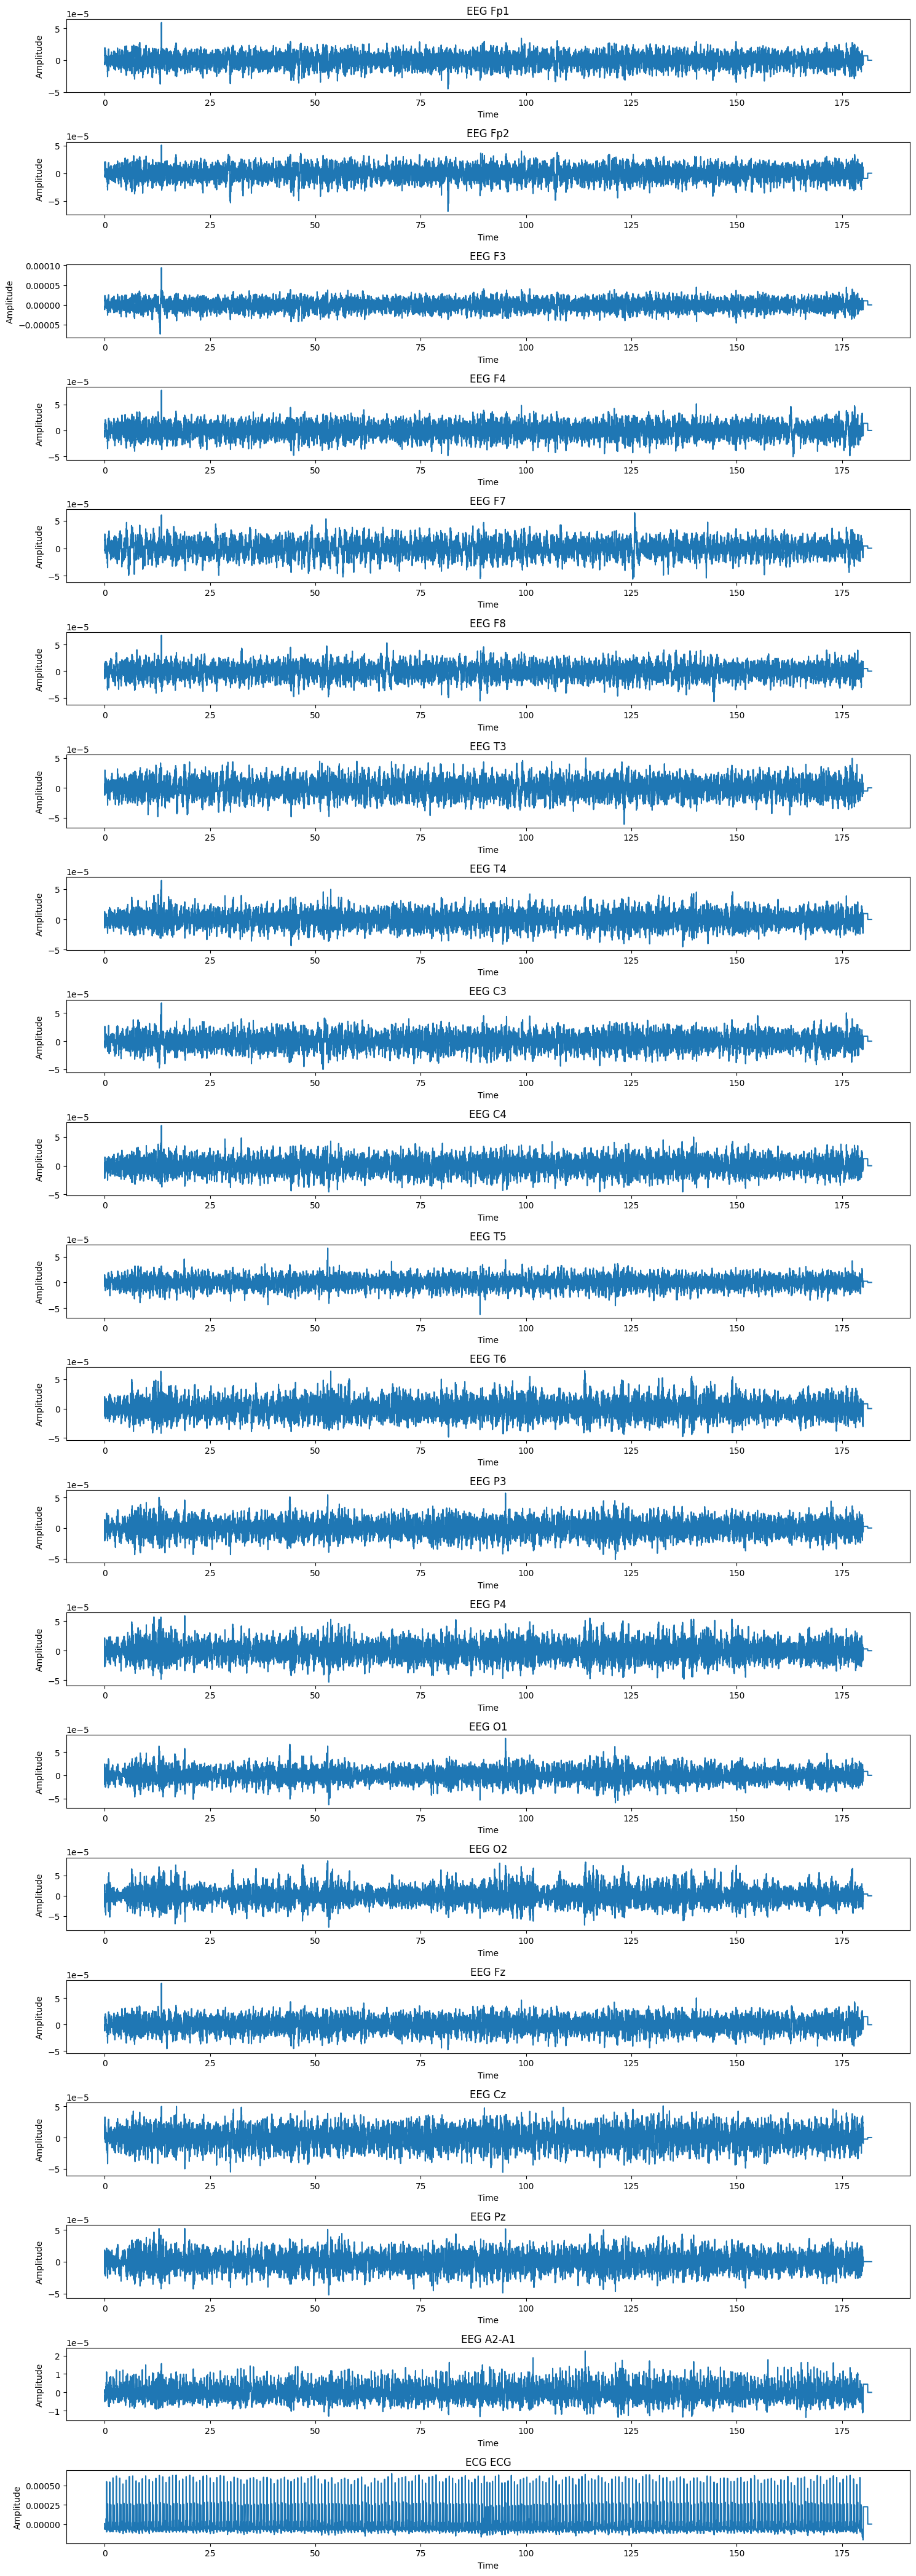

In [32]:
plot_signals(data, times, labels)

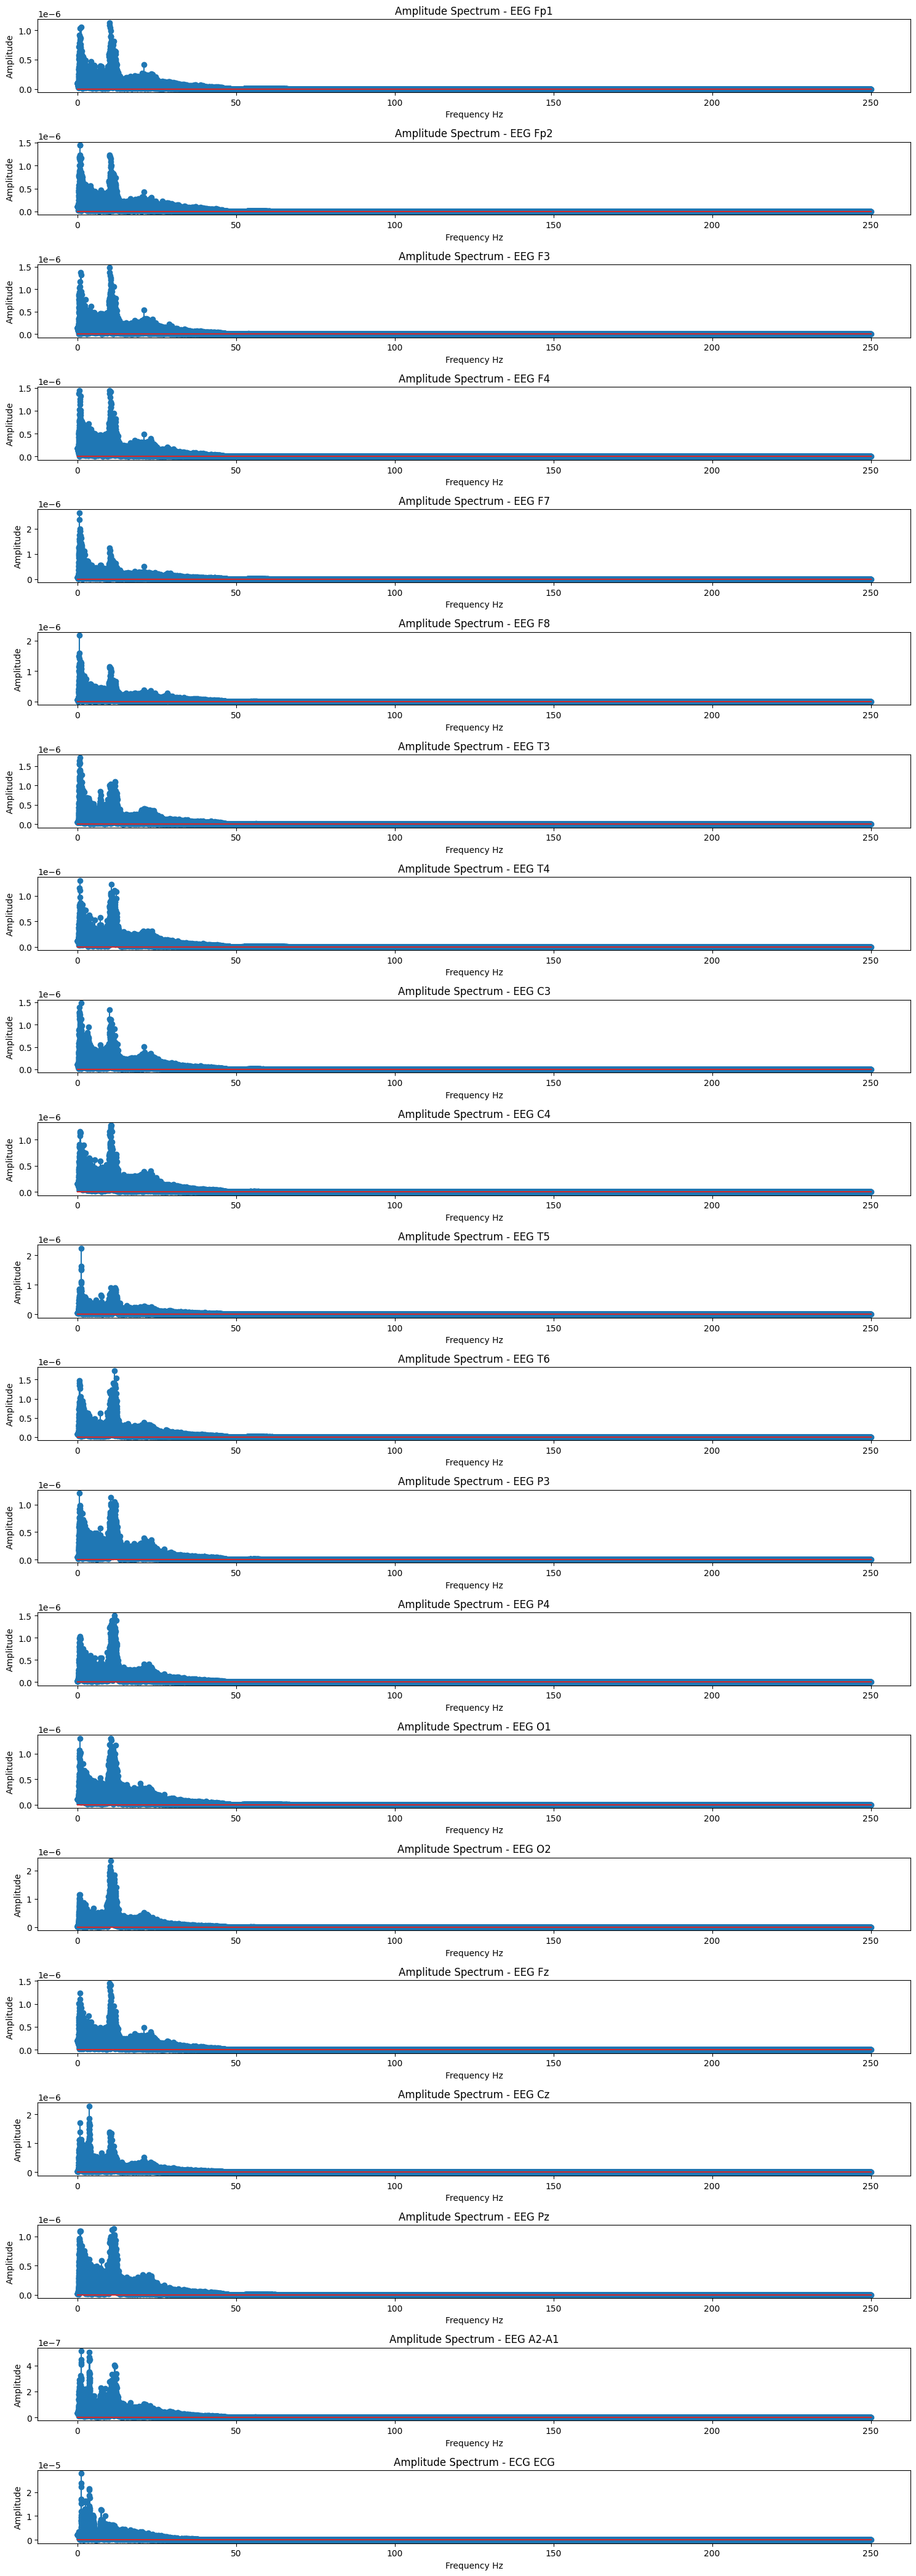

In [17]:
plot_signals(data, times, labels, plot_type="spectrum")

# Feature extraction

In [18]:
X_train.shape
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)
X_train_2d.shape

(57, 651000)

## Wavelets

In [19]:
def extract_wavelet_features(data, wavelet='db4', level=5):
    features = []
    for signal in data:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        features.append(np.concatenate(coeffs))

    return np.array(features)

## FFT Features

In [20]:
def extract_fft_features(data, sampling_rate = 500):
    n_channels, n_timepoints = data.shape
    len_fft = n_timepoints // 2 + 1 if n_timepoints % 2 == 0 else (n_timepoints + 1) // 2
    fft_features = np.empty((n_channels, n_timepoints // 2))

    for i in range(n_channels):
        spectrum = np.fft.fft(data[i, :])
        freq_x = np.fft.fftfreq(data.shape[-1], 1 / sampling_rate)
        positive_freq_indices = np.where(freq_x >= 0)
        spectrum = spectrum[positive_freq_indices]

        
        fft_features[i, :] = spectrum

    return fft_features

In [54]:
def get_feature_dataset(X, feature_extraction_type="wavelet"):
    X_feat = []
    if feature_extraction_type == "wavelet":
        extract = extract_wavelet_features
    else:
        extract = extract_fft_features
    for i in range(X.shape[0]):
        norm_data = normalizing_data(extract(X[i, :]))
        X_feat.append(norm_data)
    
    return np.array(X_feat)
        


## Autoencoder

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Flatten, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import LambdaCallback

2023-12-13 18:59:46.734264: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [65]:
def train_autoencoder(X_train, X_test, input_shape, epochs=200, batch_size=16, n_bottleneck = 100):
    visible = Input(shape=input_shape)  
    flattened = Flatten()(visible)
    e = Dense(input_shape[0] * input_shape[1])(flattened)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)

    n_bottleneck = n_bottleneck
    bottleneck = Dense(n_bottleneck)(e)


    d = Dense(input_shape[0] * input_shape[1])(bottleneck)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)


    reshaped = Reshape(input_shape)(d)

    output = Dense(input_shape[0] * input_shape[1], activation='linear')(reshaped)

    model = Model(inputs=visible, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    print_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch + 1}/{epochs}, "
                                               f"Loss: {logs['loss']:.4f}, "
                                               f"Validation Loss: {logs['val_loss']:.4f}")
    )

    print(model.summary())

    # history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_test, X_test), callbacks=[print_callback])

    # encoder = Model(inputs=visible, outputs=bottleneck)


    return model, encoder, history


In [74]:

autoencoder_model, encoder_model, training_history = train_autoencoder(X_train, X_test, X_train[0].shape, epochs=5, batch_size=1)

: 

Unfortunately, autoencoder failed and crashed the kernel

## PYOD

In [ ]:
from pyod.models.auto_encoder import AutoEncoder

In [ ]:
encoding_dim = 20
ae = AutoEncoder(hidden_neurons =[encoding_dim, int(encoding_dim / 2), int(encoding_dim / 2), encoding_dim])
ae.fit(X_train_2d)

This one also used all my RAM, sqap and crashed kernel T_T

# Dimensionality reduction

In [22]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split

In [23]:
def feature_extraction_pipeline(X, Y, n_components = 30, feature_extraction_type="wavelet", dimensionality_reduction_type=None):
    print(f"[INFO] Extracting features: {feature_extraction_type} features")
    X_feat = get_feature_dataset(X, feature_extraction_type)
    X_feat = X_feat.reshape(X_feat.shape[0], -1)

    print(f"[INFO] Reducing dimensionality: {dimensionality_reduction_type}")

    if dimensionality_reduction_type is None:
        pass
    elif not isinstance(dimensionality_reduction_type, str):
        raise ValueError("Wrong dimensionality reduction type")
    elif dimensionality_reduction_type.lower() == "pca":
        n_components = min(n_components, X_feat.shape[0])
        dim_reduction = PCA(n_components=n_components)
        X_feat = dim_reduction.fit_transform(X_feat)
        X_train, X_test, y_train, y_test = train_test_split(X_feat, Y, test_size=0.2, random_state=42)
    elif dimensionality_reduction_type.lower() == "ica":
        n_components = min(n_components, X_feat.shape[0])
        dim_reduction = FastICA(n_components=n_components, random_state=0)
        X_feat = dim_reduction.fit_transform(X_feat)
        X_train, X_test, y_train, y_test = train_test_split(X_feat, Y, test_size=0.2, random_state=42)
    else:
        selector = SelectKBest(f_classif, k=n_components)
        X_train, X_test, y_train, y_test = train_test_split(X_feat, Y, test_size=0.2, random_state=42)
        X_train = selector.fit_transform(X_train, y_train)
        X_test = selector.transform(X_test)

    print(f"[INFO] number of components: {n_components}")
    
    return X_train, X_test, y_train, y_test, n_components

        
        



# Classifier training and feature importance

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [48]:
X, Y = get_x_y("eeg_menthal_arithmetics_dataset.csv", label="recording_state")


Extracting EDF parameters from /Users/shevdan/Documents/Programming/signals/project/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /Users/shevdan/Documents/Programming/signals/project/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Extracting EDF parameters from /Users/shevdan/Documents/Programming/signals/project/eeg-during-mental-arithmetic-tasks-1.0.0/Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /Users/shevdan/Documents/Programming/signals/project/eeg-during-mental-arithmetic-tasks-1.0.0/Subject01_2.edf...
EDF fil

In [50]:
print(f"NUMBER OF OBSERVATIONS FOR ML MODEL: {X.shape[0]}. TRAIN: {round(0.8 * X.shape[0])}, TEST: {round(0.2 * X.shape[0])}")

NUMBER OF OBSERVATIONS FOR ML MODEL: 72. TRAIN: 58, TEST: 14


In [25]:
features = ["wavelet", "fft"]
dim_reduction_type = ["pca", "ica", "k-best"]
n_components = list(range(10, 201, 10))

In [26]:
RESULTS = []

In [27]:
for feat in features:
    for dim_reduct in dim_reduction_type:
        n_prev = -1
        for n_comp in n_components:
            if n_components - 10 < n_prev:
                break
            X_train, X_test, y_train, y_test, num_comp_used = feature_extraction_pipeline(X, Y, feature_extraction_type=feat, dimensionality_reduction_type=dim_reduct, n_components=n_comp)
            n_prev = num_comp_used
            clf = RandomForestClassifier()
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            importances = clf.feature_importances_
            print(f"[INFO] {feat} features, {dim_reduct} dimensionality reduction, {num_comp_used} components. Accuracy: {acc}")
            print("----------------------------------------------------------------------------")
            RESULTS.append((feat, dim_reduct, num_comp_used, acc, importances))
        print(f"======================================= END OF {dim_reduct} =======================================")
    print(f"======================================= END OF {feat} =======================================")

            

[INFO] Extracting features: wavelet features
[INFO] Reducing dimensionality: pca
[INFO] number of components: 10
[INFO] wavelet features, pca dimensionality reduction, 10 components. Accuracy: 0.6666666666666666
----------------------------------------------------------------------------
[INFO] Extracting features: wavelet features
[INFO] Reducing dimensionality: pca
[INFO] number of components: 20
[INFO] wavelet features, pca dimensionality reduction, 20 components. Accuracy: 0.5333333333333333
----------------------------------------------------------------------------
[INFO] Extracting features: wavelet features
[INFO] Reducing dimensionality: pca
[INFO] number of components: 30
[INFO] wavelet features, pca dimensionality reduction, 30 components. Accuracy: 0.7333333333333333
----------------------------------------------------------------------------
[INFO] Extracting features: wavelet features
[INFO] Reducing dimensionality: pca
[INFO] number of components: 40
[INFO] wavelet featu

/Users/shevdan/Documents/Programming/signals/project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


[INFO] number of components: 72
[INFO] wavelet features, ica dimensionality reduction, 72 components. Accuracy: 0.5333333333333333
----------------------------------------------------------------------------
[INFO] Extracting features: wavelet features
[INFO] Reducing dimensionality: ica


/Users/shevdan/Documents/Programming/signals/project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


[INFO] number of components: 72
======================================= END OF ica =======================================
[INFO] Extracting features: wavelet features
[INFO] Reducing dimensionality: k-best
[INFO] number of components: 10
[INFO] wavelet features, k-best dimensionality reduction, 10 components. Accuracy: 0.7333333333333333
----------------------------------------------------------------------------
[INFO] Extracting features: wavelet features
[INFO] Reducing dimensionality: k-best
[INFO] number of components: 20
[INFO] wavelet features, k-best dimensionality reduction, 20 components. Accuracy: 0.9333333333333333
----------------------------------------------------------------------------
[INFO] Extracting features: wavelet features
[INFO] Reducing dimensionality: k-best
[INFO] number of components: 30
[INFO] wavelet features, k-best dimensionality reduction, 30 components. Accuracy: 0.9333333333333333
---------------------------------------------------------------------

/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: pca
[INFO] number of components: 10
[INFO] fft features, pca dimensionality reduction, 10 components. Accuracy: 0.6666666666666666
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: pca
[INFO] number of components: 20
[INFO] fft features, pca dimensionality reduction, 20 components. Accuracy: 0.4666666666666667
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: pca
[INFO] number of components: 30
[INFO] fft features, pca dimensionality reduction, 30 components. Accuracy: 0.3333333333333333
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: pca
[INFO] number of components: 40
[INFO] fft features, pca dimensionality reduction, 40 components. Accuracy: 0.6
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: pca
[INFO] number of components: 50
[INFO] fft features, pca dimensionality reduction, 50 components. Accuracy: 0.5333333333333333
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: pca
[INFO] number of components: 60
[INFO] fft features, pca dimensionality reduction, 60 components. Accuracy: 0.5333333333333333
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: pca
[INFO] number of components: 70
[INFO] fft features, pca dimensionality reduction, 70 components. Accuracy: 0.4666666666666667
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: pca
[INFO] number of components: 72
[INFO] fft features, pca dimensionality reduction, 72 components. Accuracy: 0.6
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: pca
[INFO] number of components: 72
======================================= END OF pca =======================================
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: ica
[INFO] number of components: 10
[INFO] fft features, ica dimensionality reduction, 10 components. Accuracy: 0.5333333333333333
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: ica
[INFO] number of components: 20
[INFO] fft features, ica dimensionality reduction, 20 components. Accuracy: 0.6
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: ica
[INFO] number of components: 30
[INFO] fft features, ica dimensionality reduction, 30 components. Accuracy: 0.5333333333333333
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: ica
[INFO] number of components: 40
[INFO] fft features, ica dimensionality reduction, 40 components. Accuracy: 0.4
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: ica
[INFO] number of components: 50
[INFO] fft features, ica dimensionality reduction, 50 components. Accuracy: 0.5333333333333333
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: ica
[INFO] number of components: 60
[INFO] fft features, ica dimensionality reduction, 60 components. Accuracy: 0.4666666666666667
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: ica
[INFO] number of components: 70
[INFO] fft features, ica dimensionality reduction, 70 components. Accuracy: 0.4666666666666667
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: ica


/Users/shevdan/Documents/Programming/signals/project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


[INFO] number of components: 72
[INFO] fft features, ica dimensionality reduction, 72 components. Accuracy: 0.4666666666666667
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: ica


/Users/shevdan/Documents/Programming/signals/project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


[INFO] number of components: 72
======================================= END OF ica =======================================
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 10
[INFO] fft features, k-best dimensionality reduction, 10 components. Accuracy: 0.4666666666666667
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 20
[INFO] fft features, k-best dimensionality reduction, 20 components. Accuracy: 0.4
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 30
[INFO] fft features, k-best dimensionality reduction, 30 components. Accuracy: 0.4
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 40
[INFO] fft features, k-best dimensionality reduction, 40 components. Accuracy: 0.4
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 50
[INFO] fft features, k-best dimensionality reduction, 50 components. Accuracy: 0.5333333333333333
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 60
[INFO] fft features, k-best dimensionality reduction, 60 components. Accuracy: 0.3333333333333333
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 70
[INFO] fft features, k-best dimensionality reduction, 70 components. Accuracy: 0.4
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 80
[INFO] fft features, k-best dimensionality reduction, 80 components. Accuracy: 0.3333333333333333
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 90
[INFO] fft features, k-best dimensionality reduction, 90 components. Accuracy: 0.4
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 100
[INFO] fft features, k-best dimensionality reduction, 100 components. Accuracy: 0.4666666666666667
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 110
[INFO] fft features, k-best dimensionality reduction, 110 components. Accuracy: 0.4
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 120
[INFO] fft features, k-best dimensionality reduction, 120 components. Accuracy: 0.4666666666666667
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 130
[INFO] fft features, k-best dimensionality reduction, 130 components. Accuracy: 0.5333333333333333
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 140
[INFO] fft features, k-best dimensionality reduction, 140 components. Accuracy: 0.4666666666666667
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 150
[INFO] fft features, k-best dimensionality reduction, 150 components. Accuracy: 0.4666666666666667
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 160
[INFO] fft features, k-best dimensionality reduction, 160 components. Accuracy: 0.4
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 170
[INFO] fft features, k-best dimensionality reduction, 170 components. Accuracy: 0.4
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 180
[INFO] fft features, k-best dimensionality reduction, 180 components. Accuracy: 0.4666666666666667
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 190
[INFO] fft features, k-best dimensionality reduction, 190 components. Accuracy: 0.4
----------------------------------------------------------------------------
[INFO] Extracting features: fft features


/var/folders/ls/7nntg5jx5c32hnw3r4xtc6xr0000gp/T/ipykernel_54224/831267206.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_features[i, :] = spectrum


[INFO] Reducing dimensionality: k-best
[INFO] number of components: 200
[INFO] fft features, k-best dimensionality reduction, 200 components. Accuracy: 0.4666666666666667
----------------------------------------------------------------------------
======================================= END OF k-best =======================================
======================================= END OF fft =======================================


In [30]:
sorted_res = sorted(RESULTS, key= lambda x: x[-2], reverse=True)

In [34]:
print("BEST RESULTS")
for feat, dim_reduct, num_comp_used, acc, importances in sorted_res[:20]:
    print(f"{feat} features, {dim_reduct} dimensionality reduction, {num_comp_used} components. Accuracy: {acc}")

BEST RESULTS
wavelet features, k-best dimensionality reduction, 40 components. Accuracy: 1.0
wavelet features, k-best dimensionality reduction, 50 components. Accuracy: 1.0
wavelet features, k-best dimensionality reduction, 20 components. Accuracy: 0.9333333333333333
wavelet features, k-best dimensionality reduction, 30 components. Accuracy: 0.9333333333333333
wavelet features, k-best dimensionality reduction, 60 components. Accuracy: 0.9333333333333333
wavelet features, k-best dimensionality reduction, 100 components. Accuracy: 0.9333333333333333
wavelet features, k-best dimensionality reduction, 110 components. Accuracy: 0.9333333333333333
wavelet features, k-best dimensionality reduction, 120 components. Accuracy: 0.9333333333333333
wavelet features, k-best dimensionality reduction, 130 components. Accuracy: 0.9333333333333333
wavelet features, k-best dimensionality reduction, 140 components. Accuracy: 0.9333333333333333
wavelet features, k-best dimensionality reduction, 190 compone

In [37]:
X, Y = get_x_y("eeg_menthal_arithmetics_dataset.csv", label="count_quality")

Extracting EDF parameters from /Users/shevdan/Documents/Programming/signals/project/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Extracting EDF parameters from /Users/shevdan/Documents/Programming/signals/project/eeg-during-mental-arithmetic-tasks-1.0.0/Subject01_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Extracting EDF parameters from /Users/shevdan/Documents/Programming/signals/project/eeg-during-mental-arithmetic-tasks-1.0.0/Subject02_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Extracting EDF parameters from /Users/shevdan/Documents/Programming/signals/project/eeg-during-mental-arithmetic-tasks-1.0.0/Subject03_2.edf...
EDF fil

In [46]:
print(f"NUMBER OF OBSERVATIONS FOR ML MODEL: {X.shape[0]}. TRAIN: {round(0.8 * X.shape[0])}, TEST: {round(0.2 * X.shape[0])}")

NUMBER OF OBSERVATIONS FOR ML MODEL: 36. TRAIN: 29, TEST: 7


This is way too low, therefore i wont even train classifier on it

# Results

In [13]:
def plot_fft_wavelet_acc(components, wavelet_acc, fft_acc, dim_red_type):
    plt.figure(figsize=(10, 6))
    plt.plot(components, wavelet_acc, marker='o', linestyle='-', color='b', label="Wavelet features")
    plt.plot(components, fft_acc, marker='o', linestyle='-', color='r', label="FFT features")
    plt.title(f"Accuracy vs Number of Components. {dim_red_type}")
    plt.xlabel("Number of Components")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.xticks(components)
    plt.show()

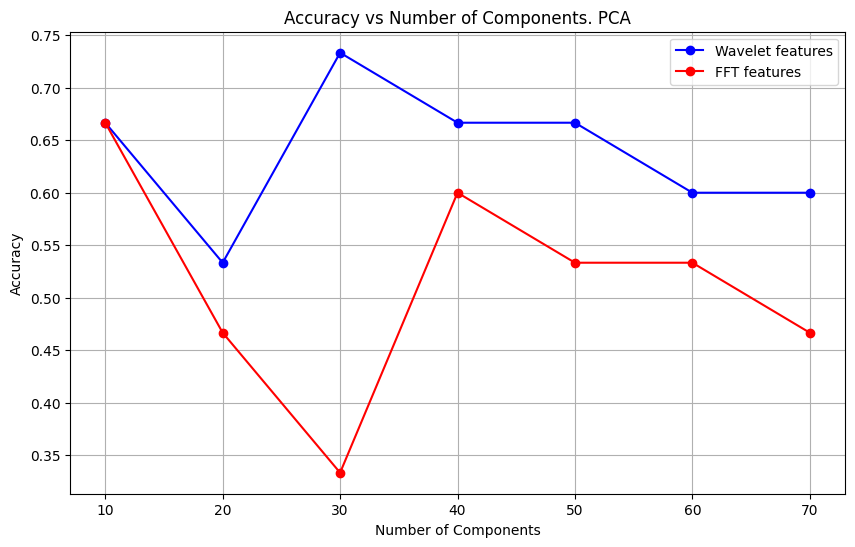

In [14]:
components = [10, 20, 30, 40, 50, 60, 70]
accuracies_wavelet_pca = [0.6666666666666666, 0.5333333333333333, 0.7333333333333333, 
              0.6666666666666666, 0.6666666666666666, 0.6, 0.6]

accuracies_fft_pca = [0.6666666666666666, 0.4666666666666667, 0.3333333333333333,
                      0.6, 0.5333333333333333, 0.5333333333333333, 0.4666666666666667]

plot_fft_wavelet_acc(components, accuracies_wavelet_pca, accuracies_fft_pca, "PCA")


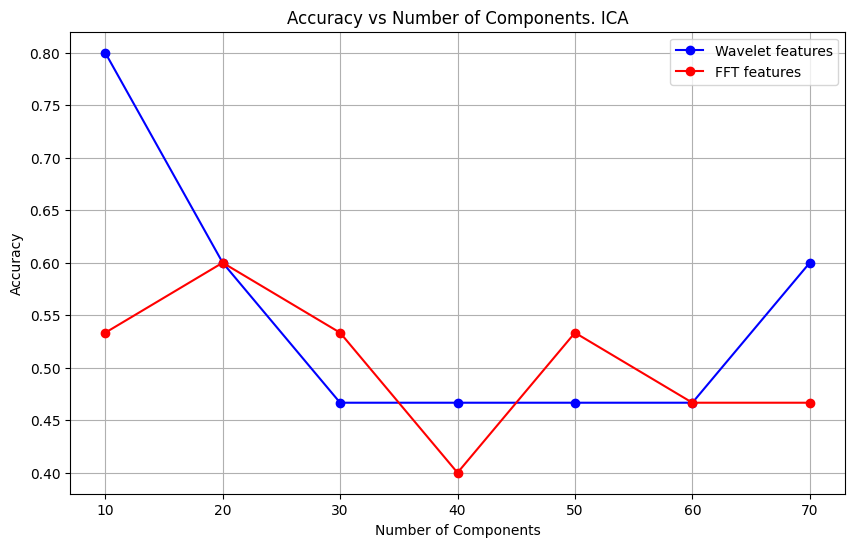

In [15]:
components_ica = [10, 20, 30, 40, 50, 60, 70]
accuracies_wavelets_ica = [0.8, 0.6, 0.4666666666666667, 0.4666666666666667, 0.4666666666666667, 0.4666666666666667, 0.6]
accuracies_fft_ica = [0.5333333333333333, 0.6, 0.5333333333333333, 
                      0.4, 0.5333333333333333, 0.4666666666666667, 0.4666666666666667]

plot_fft_wavelet_acc(components, accuracies_wavelets_ica, accuracies_fft_ica, "ICA")

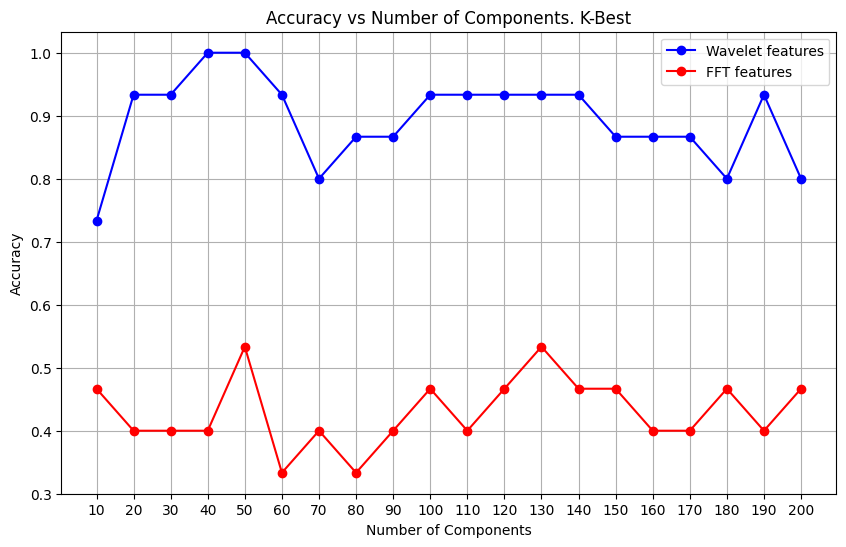

In [17]:
components_k_best = list(range(10, 201, 10))
accuracies_wavelets_k_best = [0.7333333333333333, 0.9333333333333333, 0.9333333333333333, 1.0, 1.0, 
                     0.9333333333333333, 0.8, 0.8666666666666667, 0.8666666666666667, 0.9333333333333333, 
                     0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 
                     0.8666666666666667, 0.8666666666666667, 0.8666666666666667, 0.8, 0.9333333333333333, 0.8]
accuracies_fft_k_best = [0.4666666666666667, 0.4, 0.4, 0.4, 0.5333333333333333, 
                         0.3333333333333333, 0.4, 0.3333333333333333, 0.4, 0.4666666666666667, 
                         0.4, 0.4666666666666667, 0.5333333333333333, 0.4666666666666667, 
                         0.4666666666666667, 0.4, 0.4, 0.4666666666666667, 0.4, 0.4666666666666667]



plot_fft_wavelet_acc(components_k_best, accuracies_wavelets_k_best, accuracies_fft_k_best, "K-Best")



<function matplotlib.pyplot.show(close=None, block=None)>

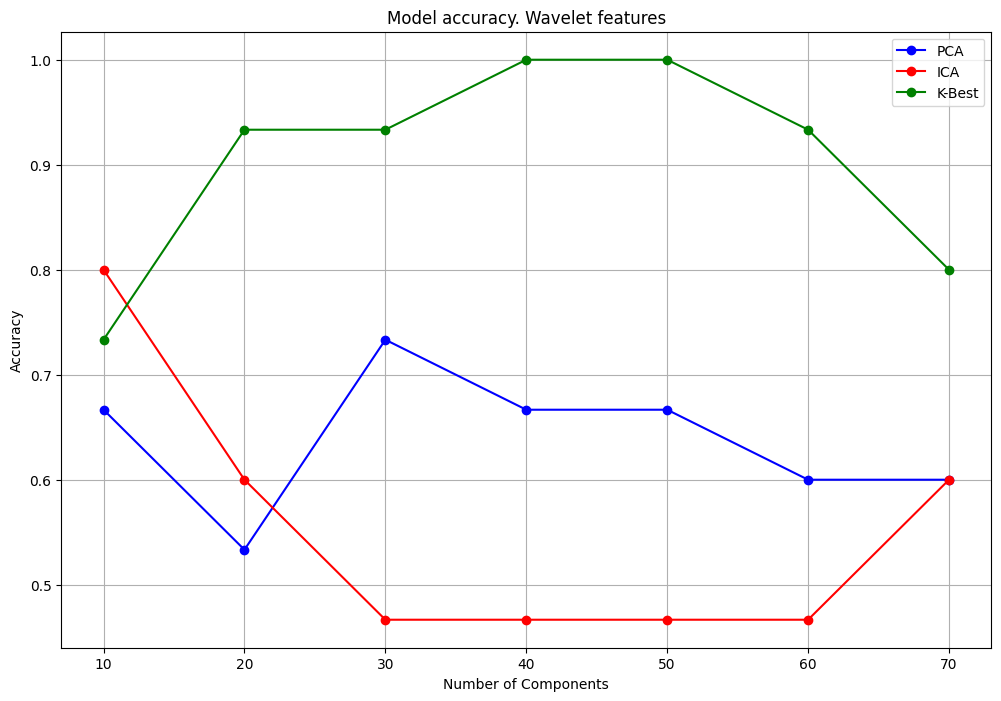

In [19]:
components = list(range(10, 71, 10))

plt.figure(figsize=(12, 8))
plt.plot(components, accuracies_wavelet_pca, marker='o', linestyle='-', color='b', label='PCA')
plt.plot(components, accuracies_wavelets_ica, marker='o', linestyle='-', color='r', label='ICA')
plt.plot(components, accuracies_wavelets_k_best[:7], marker='o', linestyle='-', color='g', label='K-Best')

plt.title("Model accuracy. Wavelet features")
plt.xlabel("Number of Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.xticks(components)
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

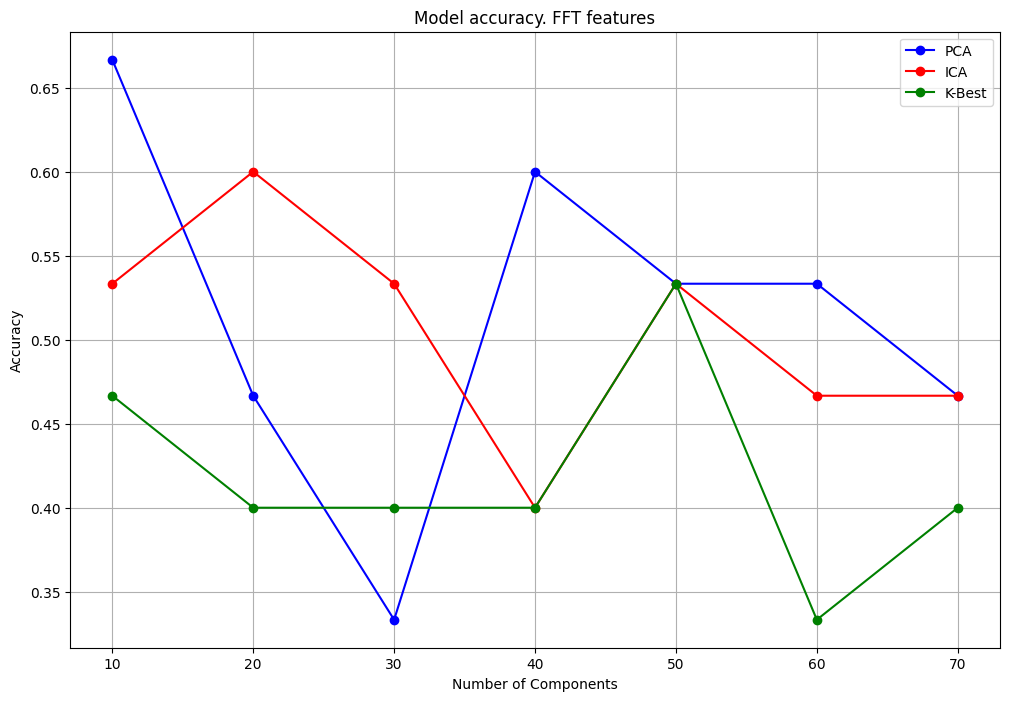

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(components, accuracies_fft_pca, marker='o', linestyle='-', color='b', label='PCA')
plt.plot(components, accuracies_fft_ica, marker='o', linestyle='-', color='r', label='ICA')
plt.plot(components, accuracies_fft_k_best[:7], marker='o', linestyle='-', color='g', label='K-Best')

plt.title("Model accuracy. FFT features")
plt.xlabel("Number of Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.xticks(components)
plt.show
